In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.aparent_all_libs import load_saved_predictor

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


<h2>Define Isoform Loss Function and SeqProp Wrapper</h2>

- Define an isoform loss function generator, optimizing for a target isoform proportion.<br/>
- Build a SeqProp wrapper that builds the generator and predictor, and executs the optimization.<br/>
- Use the continuous PWM (Softmax sequence distribution) as predictor input


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isoform_use, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    use_entropy_mse = get_margin_entropy(pwm_start=use_start, pwm_end=use_end, min_bits=use_target_bits)
    cse_entropy_mse = get_margin_entropy(pwm_start=cse_start, pwm_end=cse_end, min_bits=cse_target_bits)
    dse_entropy_mse = get_margin_entropy(pwm_start=dse_start, pwm_end=dse_end, min_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_pred_score, cut_score_pred = predictor_outputs

        #Aggregate total predicted isoform abundance from cut distribution
        #iso_pred_score = K.expand_dims(K.sum(cut_score_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)
        
        #Specify costs
        iso_loss = -1.0 * K.mean(iso_pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_pred_score, cut_score_pred = predictor_outputs

        #Aggregate total predicted isoform abundance from cut distribution
        #iso_pred_score = K.expand_dims(K.sum(cut_score_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)
        
        #Specify costs
        iso_loss = -1.0 * K.mean(iso_pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        
        self.val_loss_history.append(val_loss_value)
        
        #print("mean(" + self.val_name + ") = " + str(np.mean(val_loss_values)))

#Sequence optimization monitor during training
class StoreSequenceMonitor(Callback):
    def __init__(self, seqprop_model, sequence_encoder, run_dir="", run_prefix="", val_steps=1) :
        self.seqprop_model = seqprop_model
        self.val_steps = val_steps
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        self.edit_distance_samples = []
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        #self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        sampled_pwm = self.seqprop_model.predict(x=None, steps=self.val_steps)[2]
        
        seqs = []
        for i in range(sampled_pwm.shape[1]) :
            for j in range(sampled_pwm.shape[0]) :
                seqs.append(self.sequence_encoder.decode(sampled_pwm[j, i, :, :, 0]))
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.val_steps) + "_steps.txt", "a+") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(run_prefix, sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, library_context='simple', eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        _, valid_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if 'aparent' in layer.name and '_valversion' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        
        #train_monitor = FlexibleSeqPropCutMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Isoform Log Odds', plot_pwm_start=70-50, plot_pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.25))
        valid_monitor = FlexibleSeqPropCutMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=False, measure_func=measure_func, measure_name='Isoform Log Odds', plot_pwm_start=70-50, plot_pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=np.arange(min(n_sequences, 5)).tolist(), figsize=(12, 1.25))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        #Standard sequence decoder
        acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
        
        #Build callback for printing intermediate sequences
        store_seq_monitor = StoreSequenceMonitor(valid_generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=1)

        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            #train_history,
            #valid_history,
            store_seq_monitor
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)


<h2>Run SeqProp to Optimize Target Isoforms (Alien1 Library)</h2>

- Generate 10 PWMs per target cut position.<br/>
- Hard-code Alien1 UTR template into sequence.<br/>
- Auxiliary objectives: Punish upstream C, slightly punish G, punish poly-A runs.<br/>


In [4]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Running optimization experiment 'Alien1 Max Isoform'
Optimizing objective 0...
Epoch 1/200
250/250 [==============================] - 3s 13ms/step - loss: 243.3737
Epoch 2/200
250/250 [==============================] - 3s 10ms/step - loss: 172.3987
Epoch 3/200
250/250 [==============================] - 3s 10ms/step - loss: 120.2989
Epoch 4/200
250/250 [==============================] - 3s 10ms/step - loss: 72.9696
Epoch 5/200
250/250 [==============================] - 3s 10ms/step - loss: 31.8956
Epoch 6/200
250/250 [==============================] - 3s 10ms/step - loss: 0.4302
Epoch 7/200
250/250 [==============================] - 3s 10ms/step - loss: -27.0824
Epoch 8/200
250/250 [==============================] - 3s 10ms/step - loss: -50.1224
Epoch 9/200
250/250 [==============================] - 3s 10ms/step - loss: -75.8891
Epoch 10/200
250/250 [==============================] - 3s 10ms/step - loss: -151.8694
Epoch 11/200
250/250 [==============================] - 3s 10ms/step - lo

250/250 [==============================] - 3s 10ms/step - loss: -6168.8393
Epoch 95/200
250/250 [==============================] - 3s 10ms/step - loss: -6255.7428
Epoch 96/200
250/250 [==============================] - 3s 10ms/step - loss: -6349.1550
Epoch 97/200
250/250 [==============================] - 3s 10ms/step - loss: -6444.5627
Epoch 98/200
250/250 [==============================] - 3s 10ms/step - loss: -6544.2701
Epoch 99/200
250/250 [==============================] - 3s 10ms/step - loss: -6640.0137
Epoch 100/200
250/250 [==============================] - 3s 10ms/step - loss: -6730.4967
Epoch 101/200
250/250 [==============================] - 3s 10ms/step - loss: -6821.4033
Epoch 102/200
250/250 [==============================] - 3s 10ms/step - loss: -6903.2347
Epoch 103/200
250/250 [==============================] - 3s 10ms/step - loss: -6982.1696
Epoch 104/200
250/250 [==============================] - 3s 10ms/step - loss: -7057.9877
Epoch 105/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -9366.6029
Epoch 187/200
250/250 [==============================] - 3s 10ms/step - loss: -9373.6863
Epoch 188/200
250/250 [==============================] - 3s 10ms/step - loss: -9379.7249
Epoch 189/200
250/250 [==============================] - 3s 10ms/step - loss: -9386.3514
Epoch 190/200
250/250 [==============================] - 3s 10ms/step - loss: -9393.8097
Epoch 191/200
250/250 [==============================] - 3s 10ms/step - loss: -9401.0656
Epoch 192/200
250/250 [==============================] - 3s 10ms/step - loss: -9408.5599
Epoch 193/200
250/250 [==============================] - 3s 10ms/step - loss: -9417.7360
Epoch 194/200
250/250 [==============================] - 3s 10ms/step - loss: -9427.6522
Epoch 195/200
250/250 [==============================] - 3s 10ms/step - loss: -9434.7404
Epoch 196/200
250/250 [==============================] - 3s 10ms/step - loss: -9441.2275
Epoch 197/200
250/250 [============

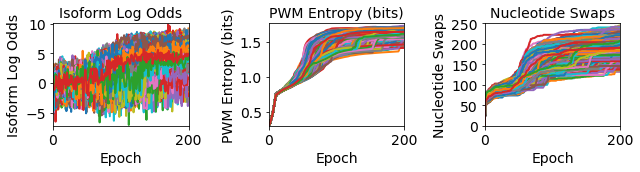

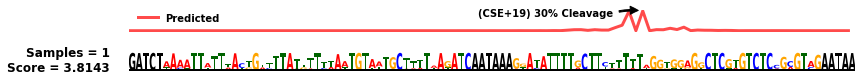

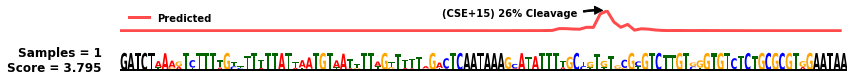

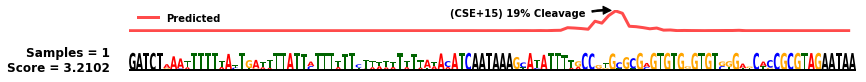

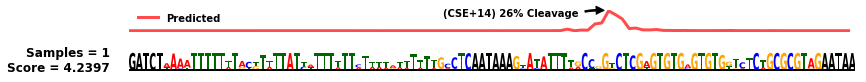

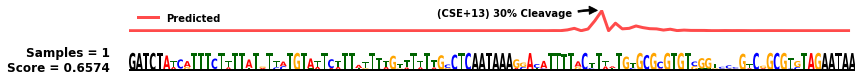

Optimizing objective 0...
Epoch 1/200
250/250 [==============================] - 3s 13ms/step - loss: 242.9150
Epoch 2/200
250/250 [==============================] - 3s 10ms/step - loss: 172.1037
Epoch 3/200
250/250 [==============================] - 3s 10ms/step - loss: 120.5200
Epoch 4/200
250/250 [==============================] - 3s 10ms/step - loss: 72.7818
Epoch 5/200
250/250 [==============================] - 3s 10ms/step - loss: 31.7291
Epoch 6/200
250/250 [==============================] - 3s 10ms/step - loss: 0.6187
Epoch 7/200
250/250 [==============================] - 3s 10ms/step - loss: -27.2306
Epoch 8/200
250/250 [==============================] - 3s 10ms/step - loss: -50.3988
Epoch 9/200
250/250 [==============================] - 3s 10ms/step - loss: -75.9145
Epoch 10/200
250/250 [==============================] - 3s 10ms/step - loss: -153.4008
Epoch 11/200
250/250 [==============================] - 3s 10ms/step - loss: -419.1649
Epoch 12/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -6347.9387
Epoch 95/200
250/250 [==============================] - 3s 10ms/step - loss: -6437.0784
Epoch 96/200
250/250 [==============================] - 3s 10ms/step - loss: -6529.1128
Epoch 97/200
250/250 [==============================] - 3s 10ms/step - loss: -6618.6214
Epoch 98/200
250/250 [==============================] - 3s 10ms/step - loss: -6706.5101
Epoch 99/200
250/250 [==============================] - 3s 10ms/step - loss: -6786.6364
Epoch 100/200
250/250 [==============================] - 3s 10ms/step - loss: -6871.0792
Epoch 101/200
250/250 [==============================] - 3s 10ms/step - loss: -6957.5520
Epoch 102/200
250/250 [==============================] - 3s 10ms/step - loss: -7042.0501
Epoch 103/200
250/250 [==============================] - 3s 10ms/step - loss: -7119.2424
Epoch 104/200
250/250 [==============================] - 3s 10ms/step - loss: -7193.5058
Epoch 105/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -9383.8564
Epoch 187/200
250/250 [==============================] - 3s 10ms/step - loss: -9388.4883
Epoch 188/200
250/250 [==============================] - 3s 10ms/step - loss: -9393.6705
Epoch 189/200
250/250 [==============================] - 3s 10ms/step - loss: -9398.4618
Epoch 190/200
250/250 [==============================] - 3s 10ms/step - loss: -9404.1499
Epoch 191/200
250/250 [==============================] - 3s 10ms/step - loss: -9410.5245
Epoch 192/200
250/250 [==============================] - 3s 10ms/step - loss: -9415.7582
Epoch 193/200
250/250 [==============================] - 3s 10ms/step - loss: -9420.2400
Epoch 194/200
250/250 [==============================] - 3s 10ms/step - loss: -9426.3113
Epoch 195/200
250/250 [==============================] - 3s 10ms/step - loss: -9432.2635
Epoch 196/200
250/250 [==============================] - 3s 10ms/step - loss: -9437.5486
Epoch 197/200
250/250 [============

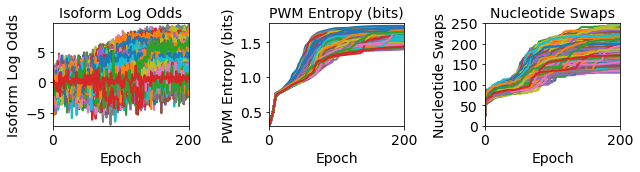

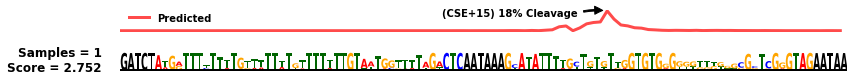

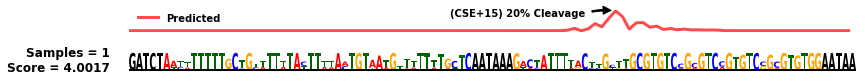

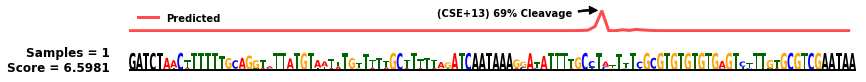

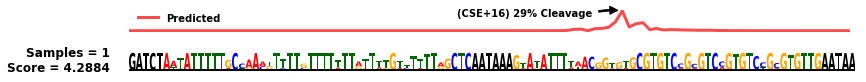

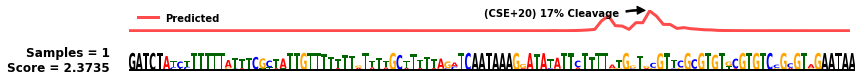

Optimizing objective 0...
Epoch 1/200
250/250 [==============================] - 3s 13ms/step - loss: 243.5635
Epoch 2/200
250/250 [==============================] - 3s 10ms/step - loss: 171.9745
Epoch 3/200
250/250 [==============================] - 3s 10ms/step - loss: 120.7897
Epoch 4/200
250/250 [==============================] - 3s 10ms/step - loss: 72.5089
Epoch 5/200
250/250 [==============================] - 3s 10ms/step - loss: 31.9366
Epoch 6/200
250/250 [==============================] - 3s 10ms/step - loss: 0.7381
Epoch 7/200
250/250 [==============================] - 3s 10ms/step - loss: -27.2464
Epoch 8/200
250/250 [==============================] - 3s 10ms/step - loss: -50.1150
Epoch 9/200
250/250 [==============================] - 3s 10ms/step - loss: -75.7159
Epoch 10/200
250/250 [==============================] - 3s 10ms/step - loss: -151.3983
Epoch 11/200
250/250 [==============================] - 3s 10ms/step - loss: -414.7458
Epoch 12/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -6322.4207
Epoch 95/200
250/250 [==============================] - 3s 10ms/step - loss: -6418.3876
Epoch 96/200
250/250 [==============================] - 3s 10ms/step - loss: -6512.3947
Epoch 97/200
250/250 [==============================] - 3s 10ms/step - loss: -6609.6418
Epoch 98/200
250/250 [==============================] - 3s 10ms/step - loss: -6702.4093
Epoch 99/200
250/250 [==============================] - 3s 10ms/step - loss: -6792.7544
Epoch 100/200
250/250 [==============================] - 3s 10ms/step - loss: -6879.1880
Epoch 101/200
250/250 [==============================] - 3s 10ms/step - loss: -6963.8996
Epoch 102/200
250/250 [==============================] - 3s 10ms/step - loss: -7050.8043
Epoch 103/200
250/250 [==============================] - 3s 10ms/step - loss: -7131.1081
Epoch 104/200
250/250 [==============================] - 3s 10ms/step - loss: -7207.2384
Epoch 105/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -9416.6107
Epoch 187/200
250/250 [==============================] - 3s 10ms/step - loss: -9425.4119
Epoch 188/200
250/250 [==============================] - 3s 10ms/step - loss: -9433.2176
Epoch 189/200
250/250 [==============================] - 3s 10ms/step - loss: -9439.4196
Epoch 190/200
250/250 [==============================] - 3s 10ms/step - loss: -9446.3628
Epoch 191/200
250/250 [==============================] - 3s 10ms/step - loss: -9453.8561
Epoch 192/200
250/250 [==============================] - 3s 10ms/step - loss: -9461.8148
Epoch 193/200
250/250 [==============================] - 3s 10ms/step - loss: -9469.3888
Epoch 194/200
250/250 [==============================] - 3s 10ms/step - loss: -9476.0812
Epoch 195/200
250/250 [==============================] - 3s 10ms/step - loss: -9481.0547
Epoch 196/200
250/250 [==============================] - 3s 10ms/step - loss: -9486.7084
Epoch 197/200
250/250 [============

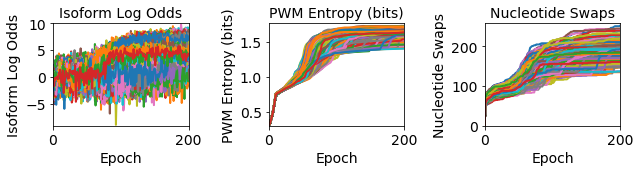

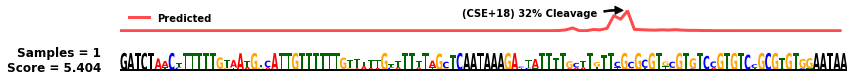

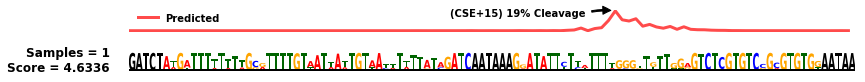

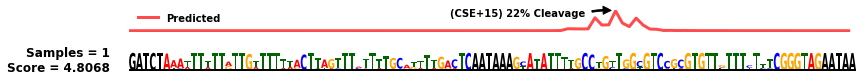

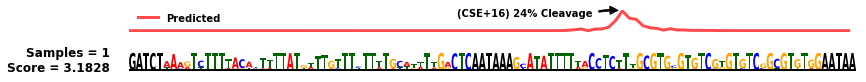

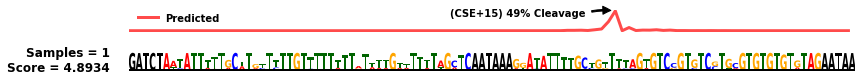

Optimizing objective 0...
Epoch 1/200
250/250 [==============================] - 3s 13ms/step - loss: 243.5511
Epoch 2/200
250/250 [==============================] - 3s 10ms/step - loss: 171.5469
Epoch 3/200
250/250 [==============================] - 3s 10ms/step - loss: 121.0409
Epoch 4/200
250/250 [==============================] - 3s 10ms/step - loss: 72.3736
Epoch 5/200
250/250 [==============================] - 3s 10ms/step - loss: 31.3279
Epoch 6/200
250/250 [==============================] - 3s 10ms/step - loss: 0.3614
Epoch 7/200
250/250 [==============================] - 3s 10ms/step - loss: -27.6717
Epoch 8/200
250/250 [==============================] - 3s 10ms/step - loss: -50.9343
Epoch 9/200
250/250 [==============================] - 3s 10ms/step - loss: -76.1643
Epoch 10/200
250/250 [==============================] - 3s 10ms/step - loss: -153.2303
Epoch 11/200
250/250 [==============================] - 3s 10ms/step - loss: -418.6228
Epoch 12/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -6235.3556
Epoch 95/200
250/250 [==============================] - 3s 10ms/step - loss: -6336.7486
Epoch 96/200
250/250 [==============================] - 3s 10ms/step - loss: -6430.9814
Epoch 97/200
250/250 [==============================] - 3s 10ms/step - loss: -6523.2251
Epoch 98/200
250/250 [==============================] - 3s 10ms/step - loss: -6610.6443
Epoch 99/200
250/250 [==============================] - 3s 10ms/step - loss: -6693.7582
Epoch 100/200
250/250 [==============================] - 3s 10ms/step - loss: -6773.0891
Epoch 101/200
250/250 [==============================] - 3s 10ms/step - loss: -6854.2884
Epoch 102/200
250/250 [==============================] - 3s 10ms/step - loss: -6933.3963
Epoch 103/200
250/250 [==============================] - 3s 10ms/step - loss: -7015.4034
Epoch 104/200
250/250 [==============================] - 3s 10ms/step - loss: -7096.8807
Epoch 105/200
250/250 [=================

250/250 [==============================] - 3s 10ms/step - loss: -9370.3243
Epoch 187/200
250/250 [==============================] - 3s 10ms/step - loss: -9377.9233
Epoch 188/200
250/250 [==============================] - 3s 10ms/step - loss: -9384.5447
Epoch 189/200
250/250 [==============================] - 3s 10ms/step - loss: -9391.3414
Epoch 190/200
250/250 [==============================] - 3s 10ms/step - loss: -9399.1981
Epoch 191/200
250/250 [==============================] - 3s 10ms/step - loss: -9407.0472
Epoch 192/200
250/250 [==============================] - 3s 10ms/step - loss: -9414.7247
Epoch 193/200
250/250 [==============================] - 3s 10ms/step - loss: -9423.3329
Epoch 194/200
250/250 [==============================] - 3s 10ms/step - loss: -9430.0180
Epoch 195/200
250/250 [==============================] - 3s 10ms/step - loss: -9436.5238
Epoch 196/200
250/250 [==============================] - 3s 10ms/step - loss: -9444.3662
Epoch 197/200
250/250 [============

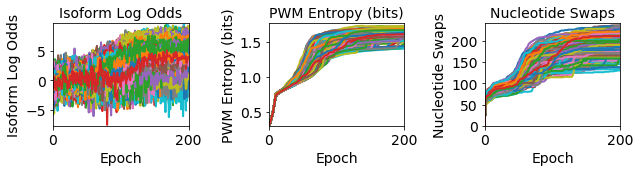

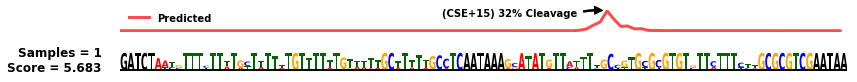

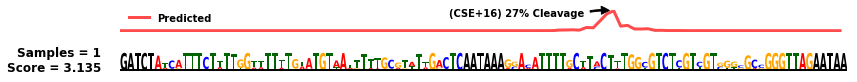

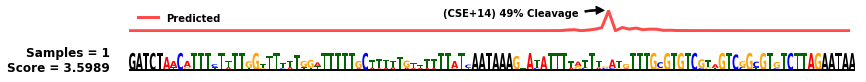

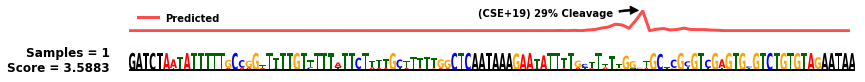

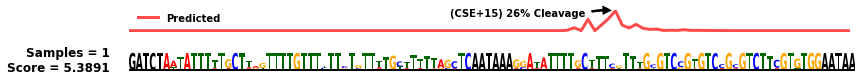

In [5]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

run_prefix = "seqprop_apa_max_isoform_simple_multi_pwm_50000_updates"

seq_template = 'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
library_context = 'simple'

iso_objectives = [1.0]

#rand_seed = 1177#14755

#Run SeqProp Optimization

print("Running optimization experiment 'Alien1 Max Isoform'")

#Number of PWMs to generate per objective
n_sequences = 4096
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Batch size per run
batch_size = 1024
#Number of epochs per objective to optimize
n_epochs = 200
#Number of steps (grad updates) per epoch
steps_per_epoch = 250
#Either 'pwm' or 'sample'
eval_mode = 'pwm'
#Normalize sequence logits
normalize_logits = False
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

n_batches = n_sequences // batch_size

acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
optimized_seqs = []

for batch_ix in range(n_batches) :

    K.clear_session()

    #set_seed(rand_seed)

    losses, val_losses = zip(*[
        get_isoform_loss(
            target_iso,
            use_start=22,
            use_end=70,
            use_target_bits=1.9,
            cse_start=70,
            cse_end=76,
            cse_target_bits=1.9,
            dse_start=76,
            dse_end=121,
            dse_target_bits=1.9,
            entropy_weight=0.0,
            punish_dn_cse=1.0,
            punish_up_c=0.0015,
            punish_dn_c=0.0001,
            punish_up_g=0.0001,
            punish_dn_g=0.0001,
            punish_up_aa=0.00025,
            punish_dn_aa=0.005
        )
        for target_iso in iso_objectives
    ])

    transforms = [
        None#get_nop_transform()
        for target_iso in iso_objectives
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(run_prefix, sequence_templates, losses, val_losses, transforms, batch_size, n_samples, n_valid_samples, library_context, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    onehots = seqprop_predictor.predict(x=None, steps=1)[2][0, :, :, :, 0]
    for i in range(onehots.shape[0]) :
        optimized_seqs.append(acgt_encoder.decode(onehots[i, :, :]))


In [6]:

#Save sequences to file
with open(run_prefix + "_4096_sequences.txt", "wt") as f:
    for i in range(len(optimized_seqs)) :
        f.write(optimized_seqs[i] + "\n")
